In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# Importing Necessary Libraries

In [69]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Data Loading and Analysis

In [70]:
df=pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

In [71]:
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [72]:
df.shape

(5110, 12)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [74]:
df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

# Removing Missing Values

In [75]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [76]:
def handle_missing_values(df):
    for column in df.columns:
        if df[column].dtype == 'object':  # Categorical column
            df[column] = df[column].fillna(df[column].mode()[0])
        else:  # Numerical column
            df[column] = df[column].fillna(df[column].median())
    return df

df = handle_missing_values(df)
print(df.isnull().sum())


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


# Removing Duplicates

In [77]:
print(df.duplicated().sum())

0


In [78]:
df = df.drop_duplicates()

# Removing Outliers using IQR Method

In [79]:
def remove_outliers(df, threshold=1.5):
    """Replaces outliers using the IQR method with the median."""
    for column in df.select_dtypes(include=['int64', 'float64']).columns.drop(["stroke", "hypertension", "heart_disease"]):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        median_value = df[column].median()  # Compute median

        # Replace outliers with the median
        df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median_value, df[column])
    
    return df
df=remove_outliers(df)

# Defining Numerical and Categorical Columns for easy analysis and Visualisation

In [80]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(["stroke", "hypertension", "heart_disease"]) 
categorical_columns = list(df.select_dtypes(include=['object']).columns)  # Convert to list
categorical_columns += ["stroke", "hypertension", "heart_disease"] 

# Finding Mean Median and Mode for each Numerical Column

In [81]:
def summary_statistics(df):
    print("\n Summary Statistics\n")
    for column in numeric_columns:
        print(f"\n {column}")
        print(f"Mean: {df[column].mean()}")
        print(f"Median: {df[column].median()}")
        print(f"Mode: {df[column].mode()[0]}")
        print(f"Skewness: {df[column].skew()}")  # Skewness

summary_statistics(df)



 Summary Statistics


 id
Mean: 36517.82935420744
Median: 36932.0
Mode: 67.0
Skewness: -0.019912979190701036

 age
Mean: 43.226614481409
Median: 45.0
Mode: 78.0
Skewness: -0.1370593225984694

 avg_glucose_level
Mean: 91.49028277886497
Median: 91.8825
Mode: 91.88499999999999
Skewness: 0.9068615722627433

 bmi
Mean: 28.248688845401173
Median: 28.1
Mode: 28.1
Skewness: 0.3088490549634691


# Plotting Frequency Distribution(using Bar Plots) of Categorical Variables

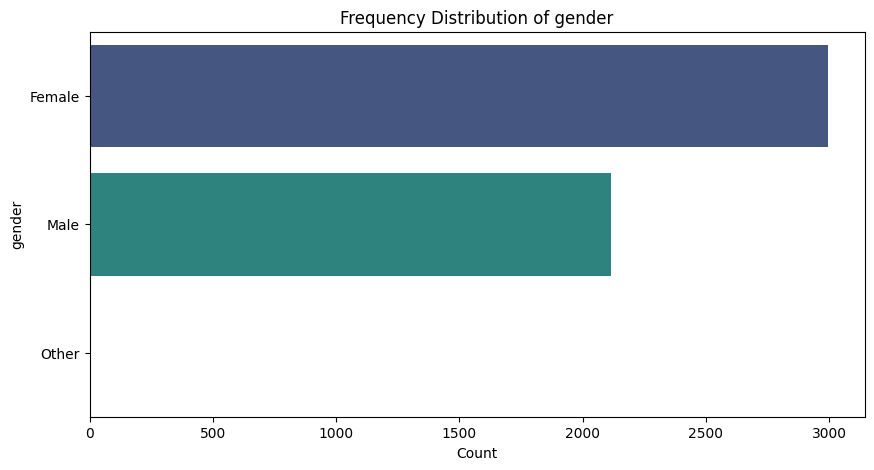

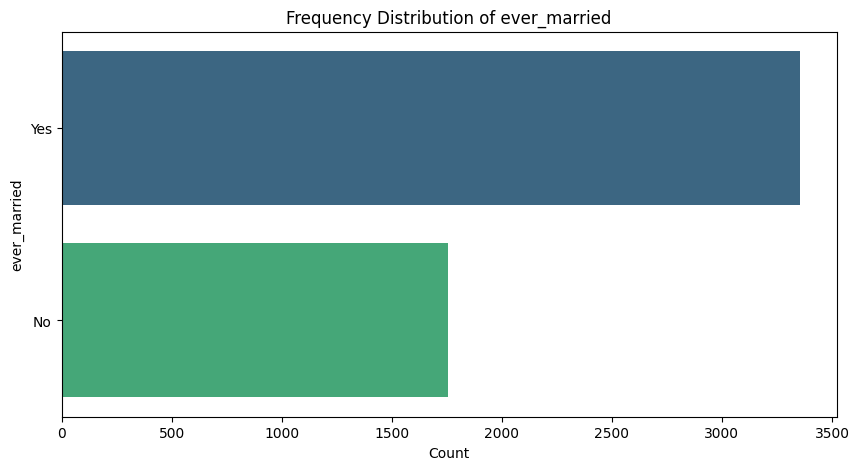

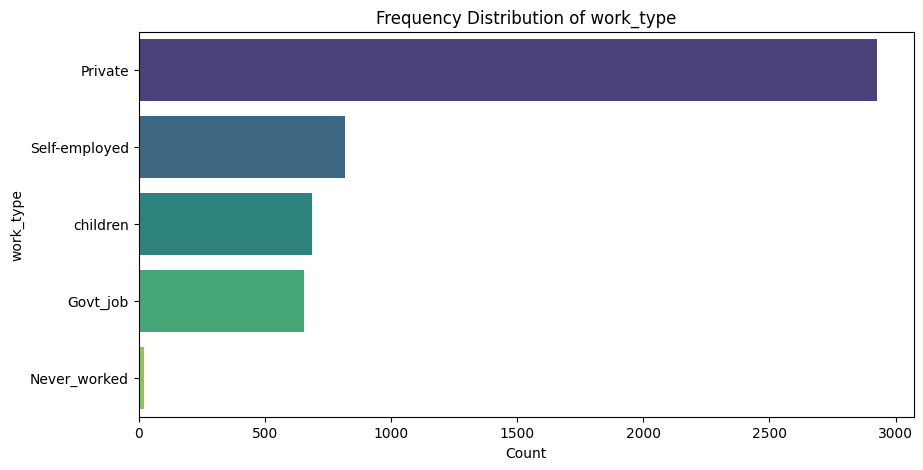

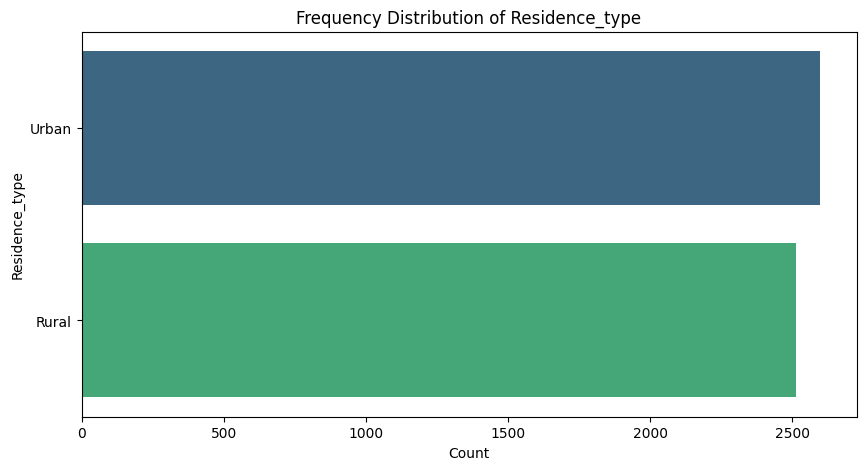

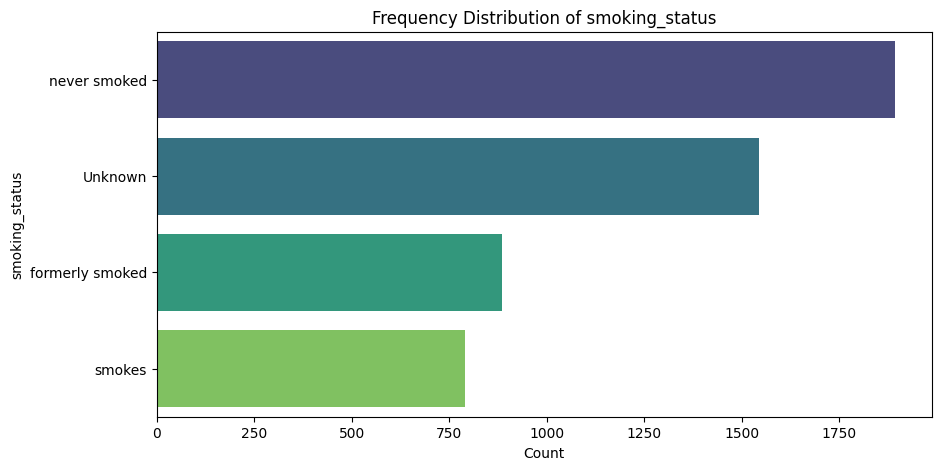

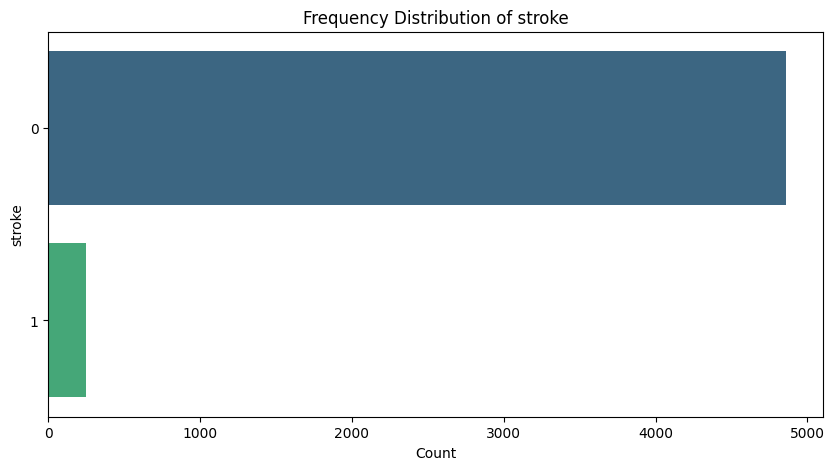

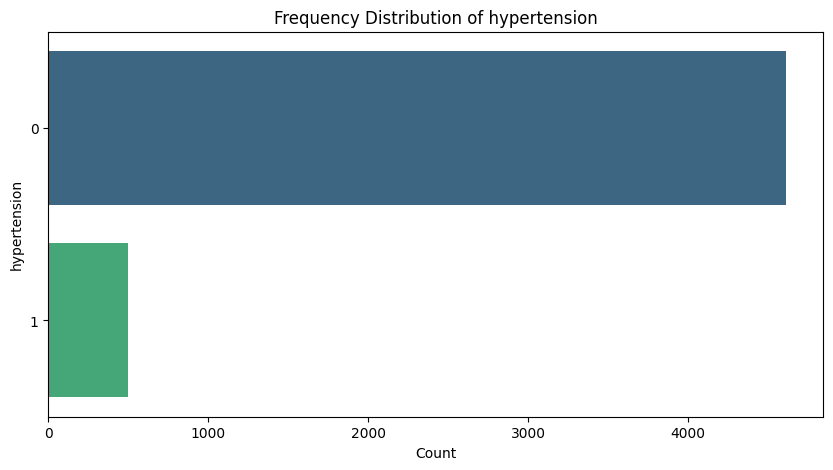

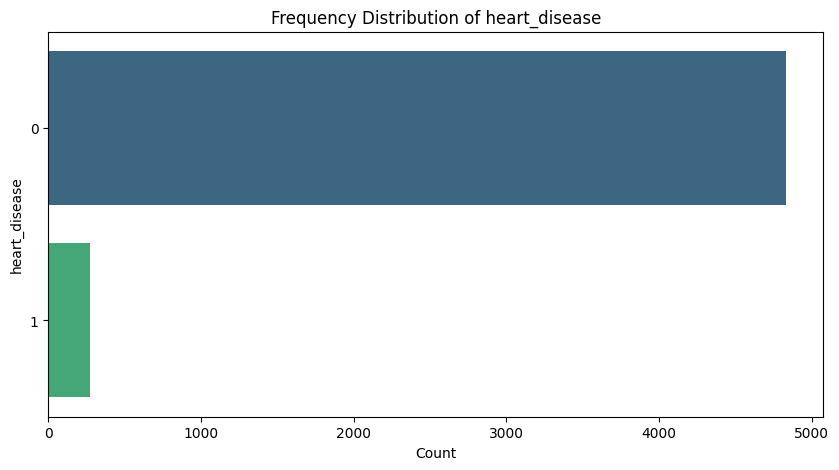

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_frequencies(df):
    for column in categorical_columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(y=df[column], order=df[column].value_counts().index, palette='viridis')
        plt.title(f'Frequency Distribution of {column}')
        plt.xlabel('Count')
        plt.ylabel(column)
        plt.show()

plot_categorical_frequencies(df)


# Plotting Box Plot and Histogram of Numeric Columns

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


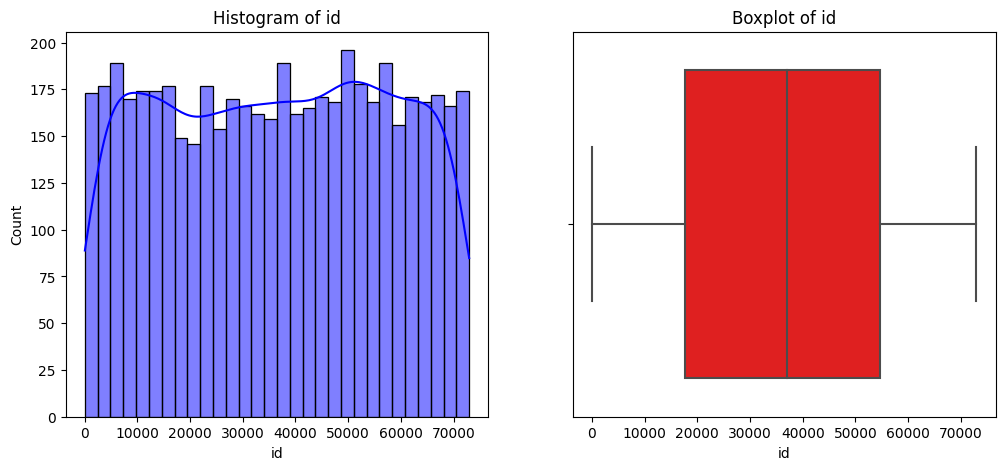

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


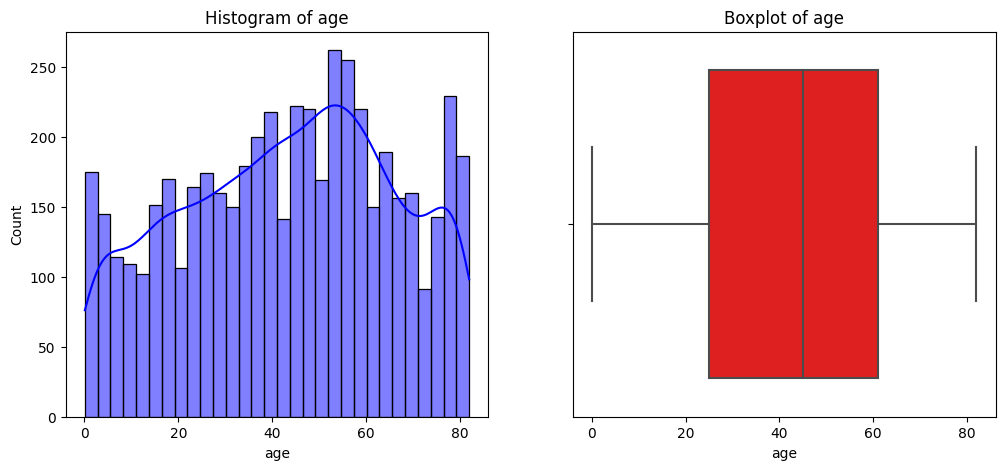

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


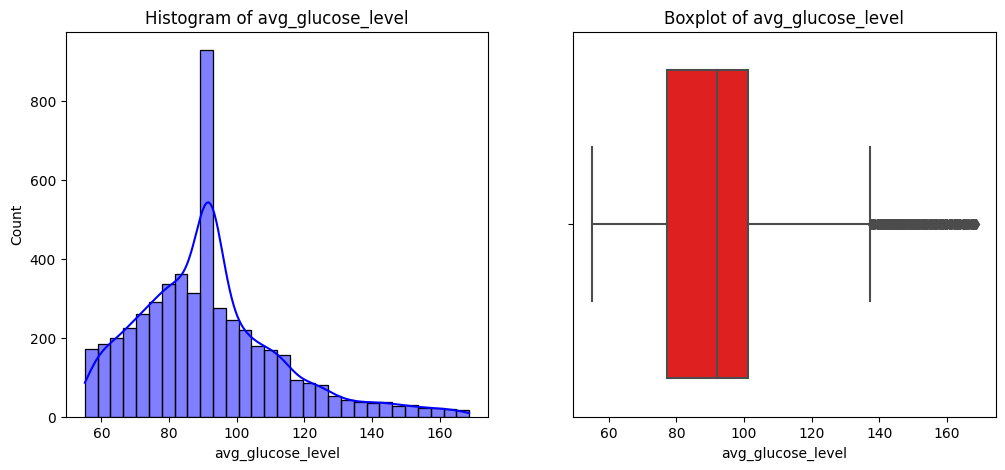

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


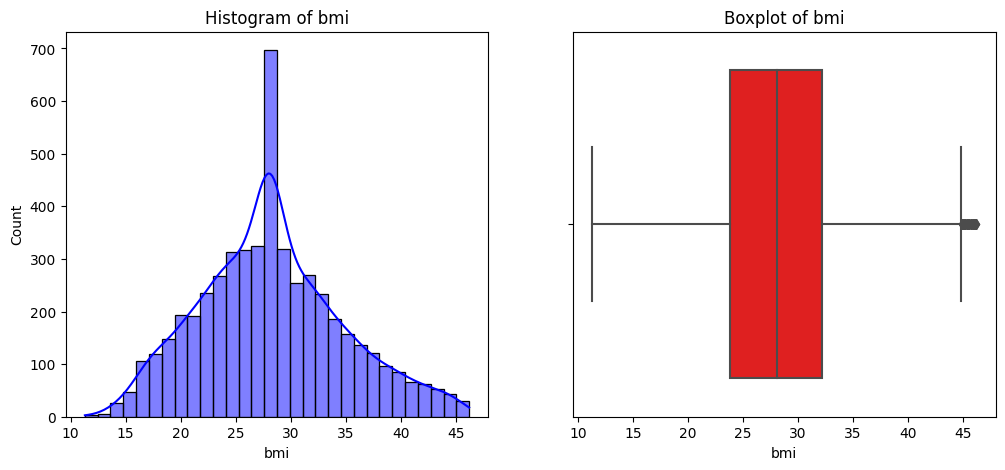

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_univariate(df):
    for column in numeric_columns:
        plt.figure(figsize=(12, 5))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=True, bins=30, color='blue')
        plt.title(f'Histogram of {column}')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column], color='red')
        plt.title(f'Boxplot of {column}')

        plt.show()
visualize_univariate(df)

# BIVARIATE ANALYSIS

# Plotting the Correlation Matrix for Numerical Columns 

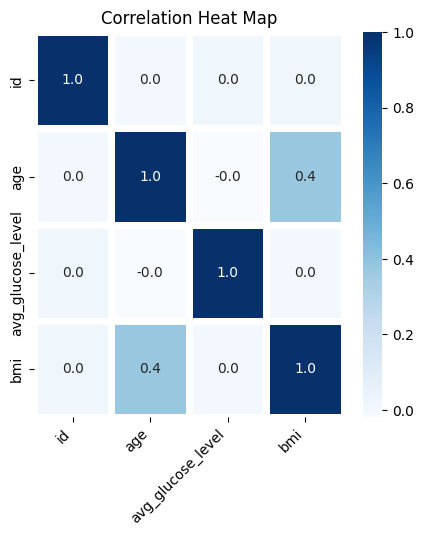

In [84]:
f, ax = plt.subplots(figsize=(5, 5))
plt.title('Correlation Heat Map')
sns.heatmap(df[numeric_columns].corr(), annot=True, linewidths=5, fmt='.1f', cmap='Blues')
plt.xticks(rotation=45, ha='right')

plt.show()

# We can also make Correlation Matrix of both Numeric and Categorical columns by Encoding them

In [85]:
import pandas as pd
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
df_new = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

id   age  hypertension  heart_disease  avg_glucose_level   bmi  \
0   9046.0  67.0             0              1             91.885  36.6   
1  51676.0  61.0             0              0             91.885  28.1   
2  31112.0  80.0             0              1            105.920  32.5   
3  60182.0  49.0             0              0             91.885  34.4   
4   1665.0  79.0             1              0             91.885  24.0   

   stroke  gender_Male  gender_Other  ever_married_Yes  \
0       1         True         False              True   
1       1        False         False              True   
2       1         True         False              True   
3       1        False         False              True   
4       1        False         False              True   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                   False               True                    False   
1                   False              False                     True   
2                   False               True                    False   
3                   False               True                    False   
4                   False              False                     True   

   work_type_children  Residence_type_Urban  smoking_status_formerly smoked  \
0               False                  True                            True   
1               False                 False                           False   
2               False                 False                           False   
3               False                  True                           False   
4               False                 False                           False   

   smoking_status_never smoked  smoking_status_smokes  
0                        False                  False  
1                         True                  False  
2                         True                  False  
3                        False                   True  
4                         True                  False

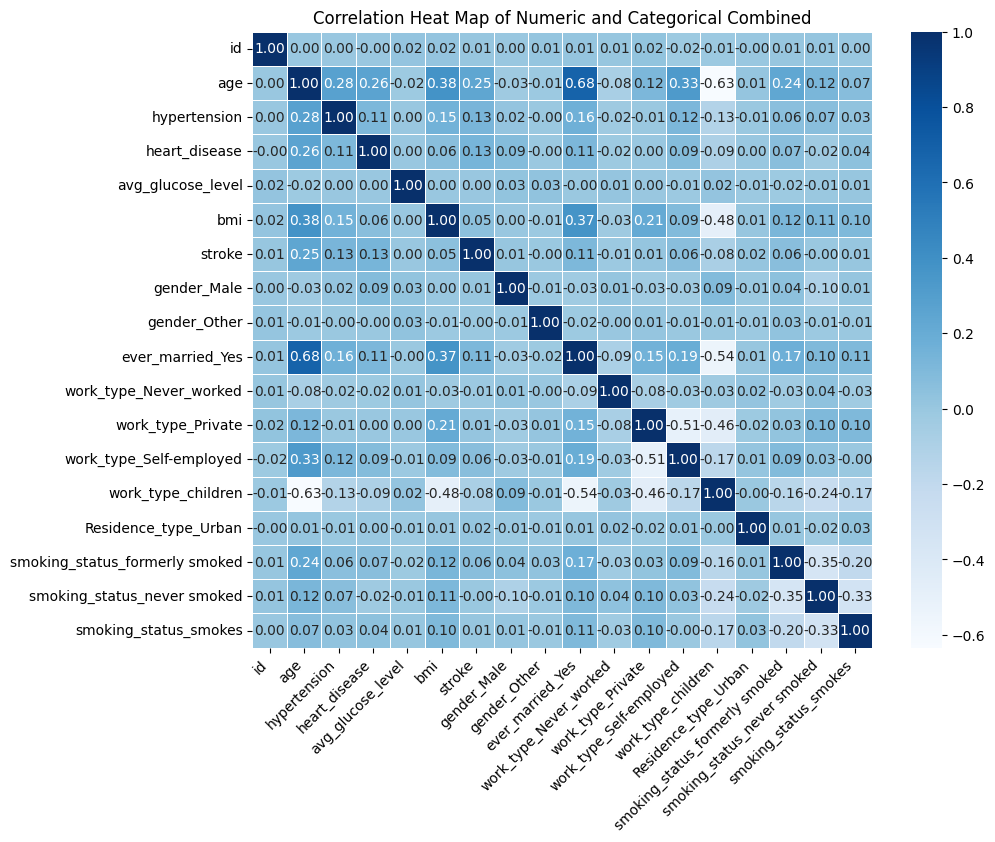

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot correlation heatmap
f, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size for better readability
plt.title('Correlation Heat Map of Numeric and Categorical Combined')

sns.heatmap(df_new.corr(), annot=True, linewidths=0.5, fmt='.2f', cmap='Blues')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()


# Plotting the Scatter Plots of Numerical v/s Numerical columns

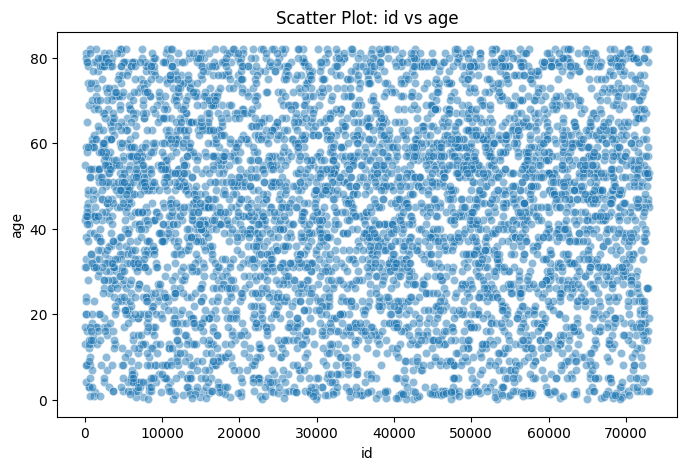

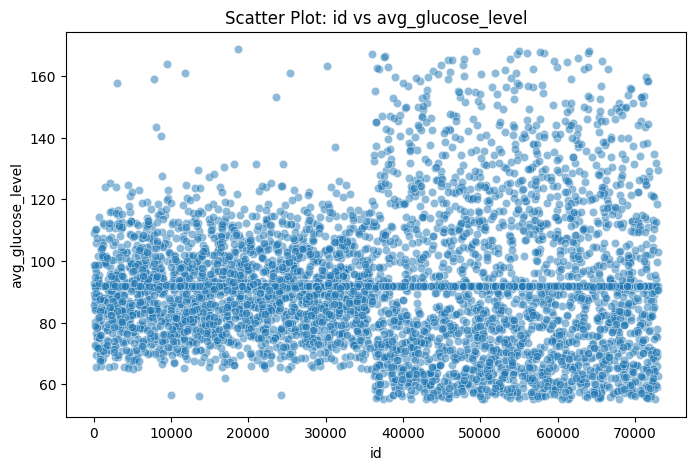

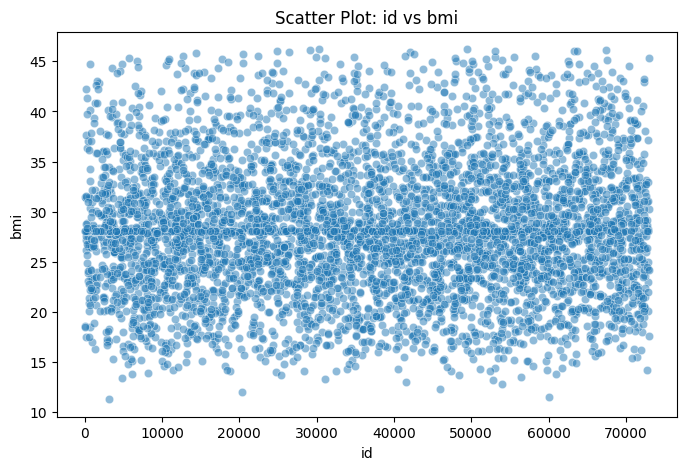

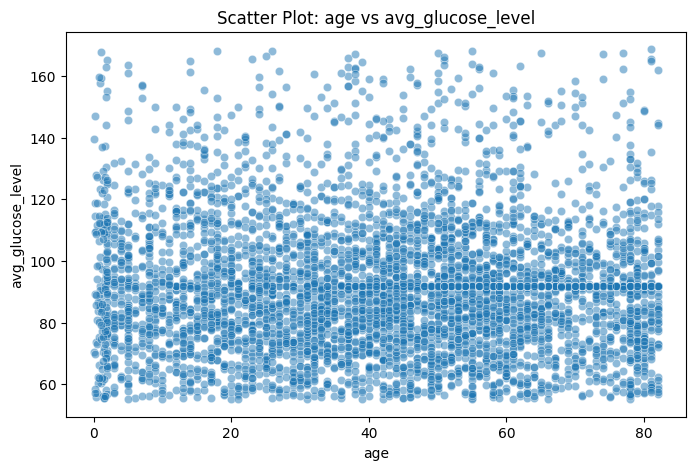

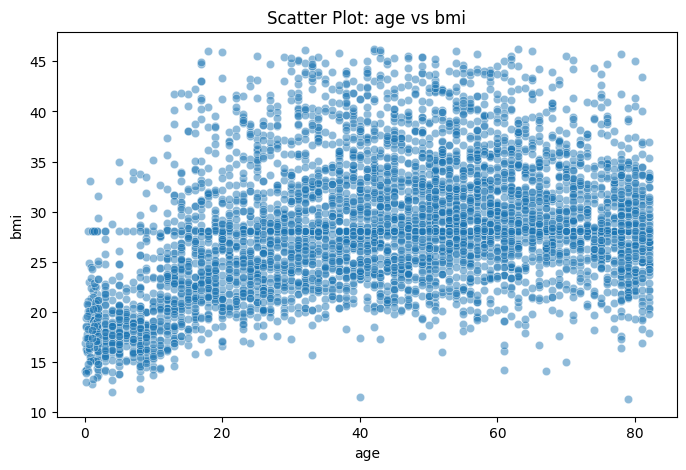

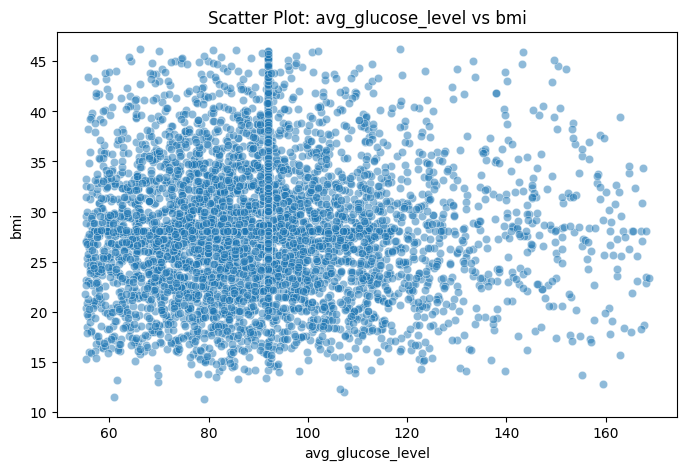

In [48]:
def scatter_plots(df):
    """Plots scatter plots for all pairs of numerical variables."""
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = numeric_columns.drop(["stroke", "hypertension", "heart_disease"]) 

    for i in range(len(numeric_columns)):
        for j in range(i + 1, len(numeric_columns)):  # Avoid duplicate pairs
            plt.figure(figsize=(8, 5))
            sns.scatterplot(x=df[numeric_columns[i]], y=df[numeric_columns[j]], alpha=0.5)
            plt.title(f"Scatter Plot: {numeric_columns[i]} vs {numeric_columns[j]}")
            plt.show()
scatter_plots(df)

# Plotting Box Violin and Bar graph for Numerical v/s Categorical 

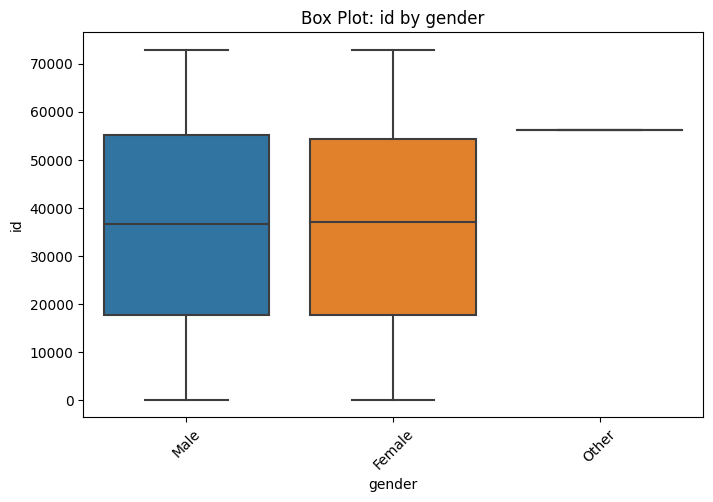

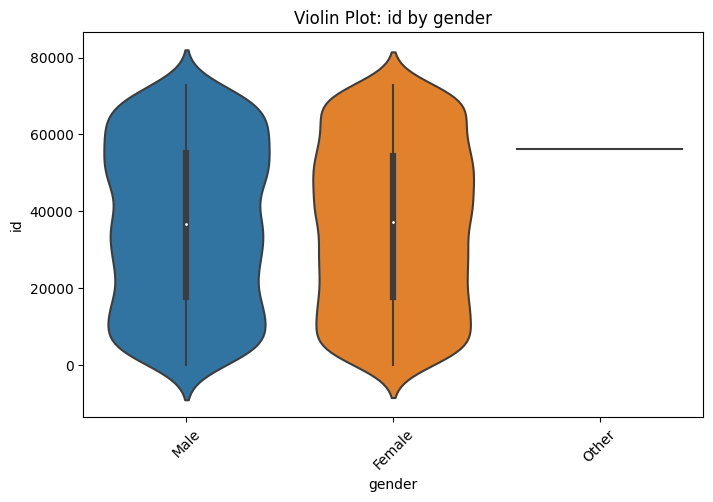

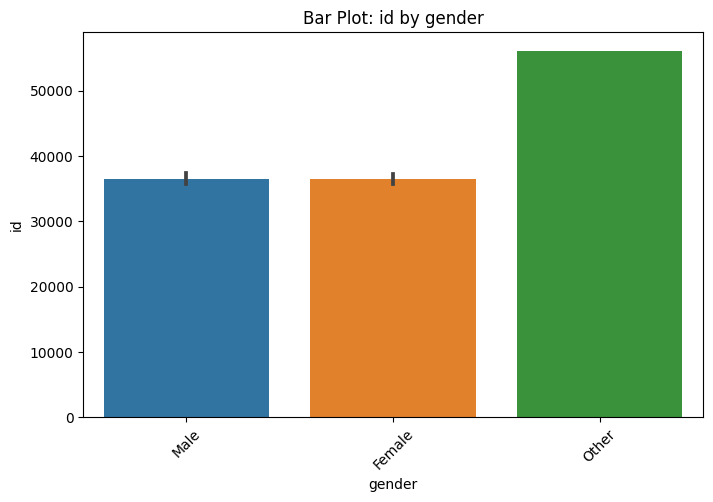

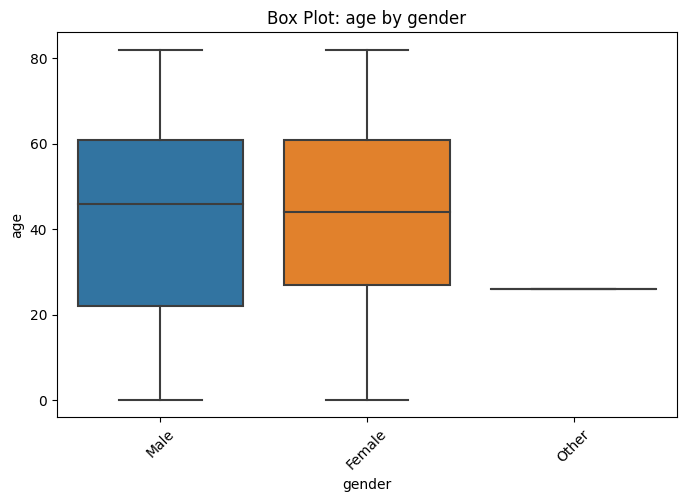

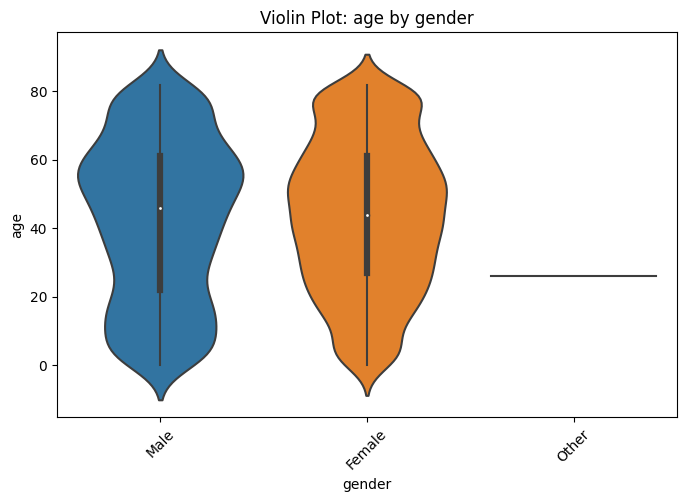

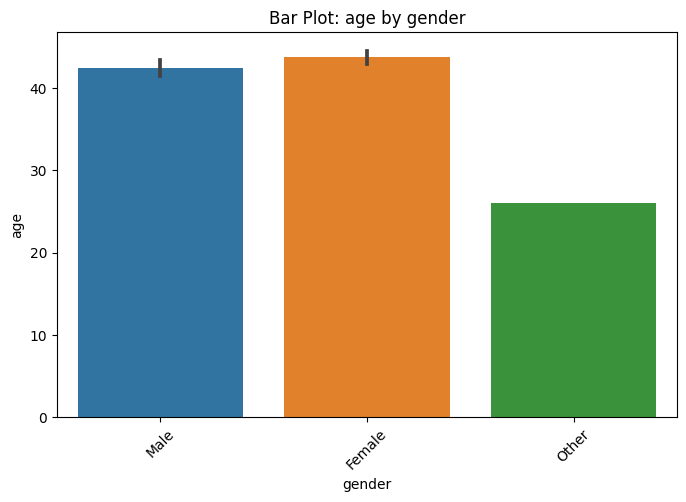

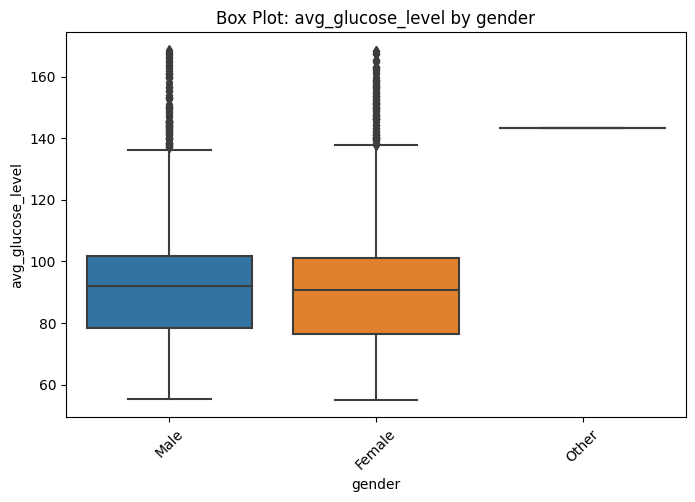

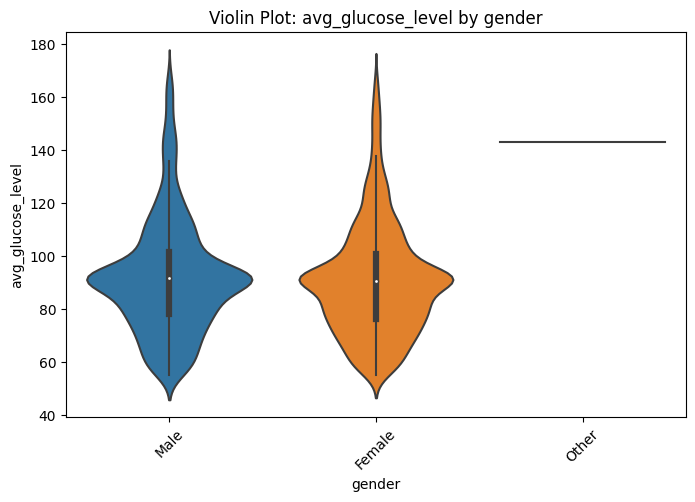

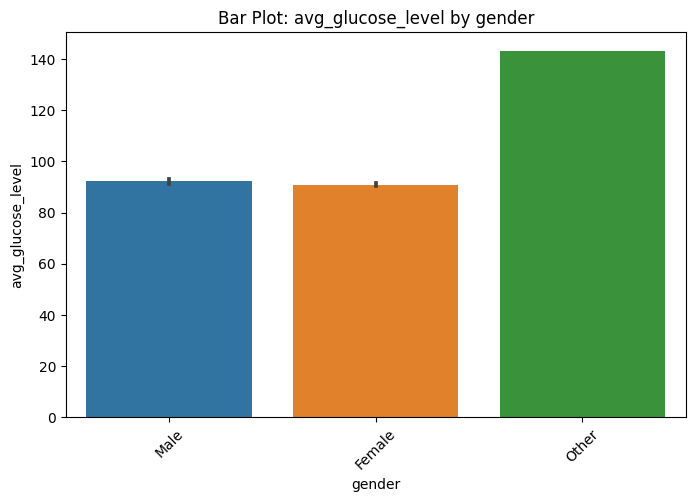

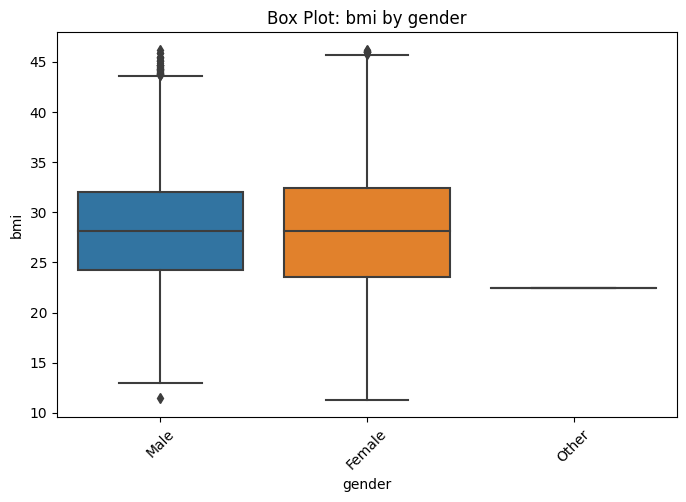

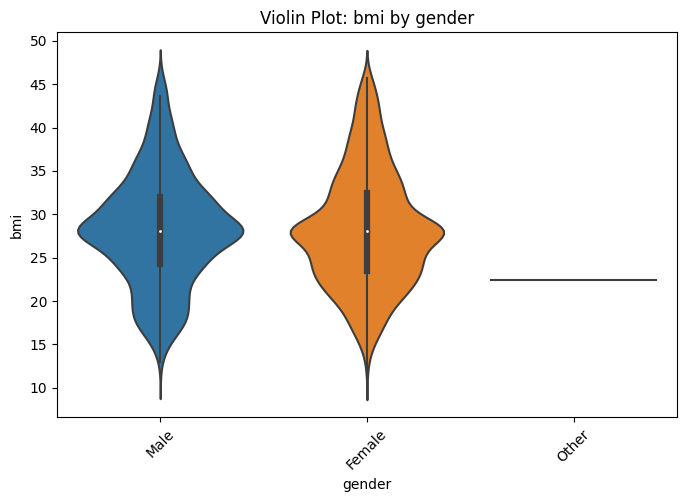

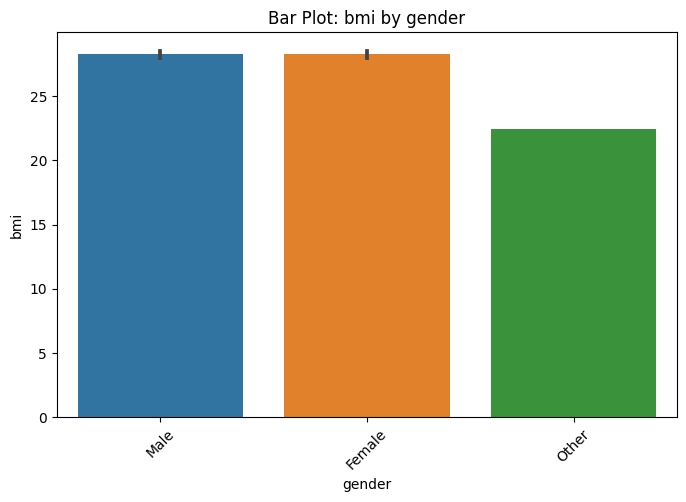

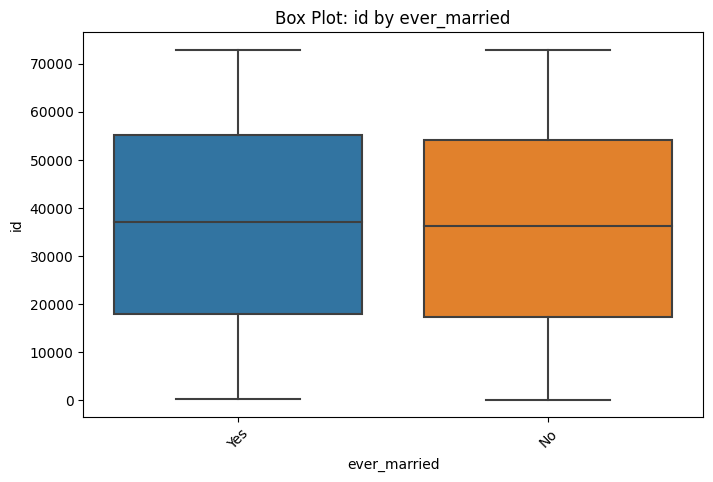

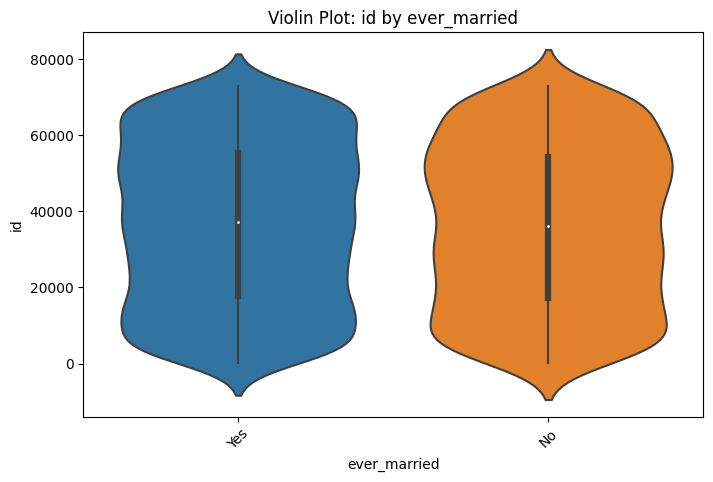

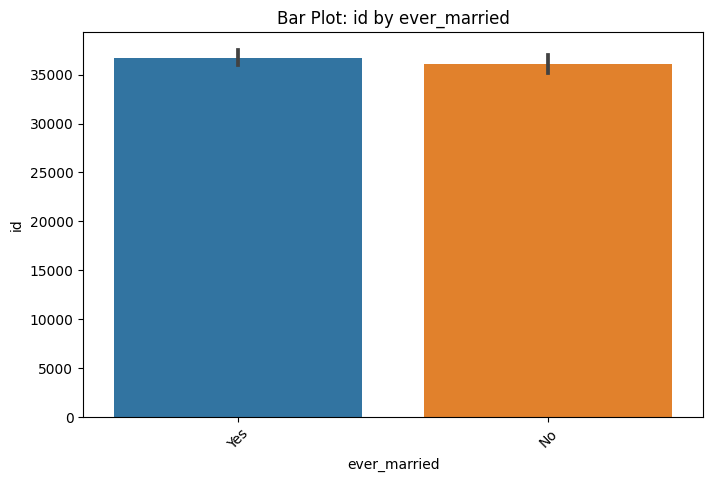

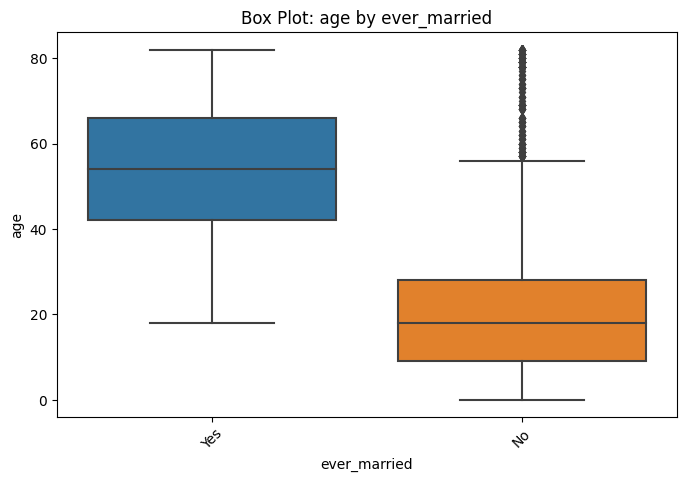

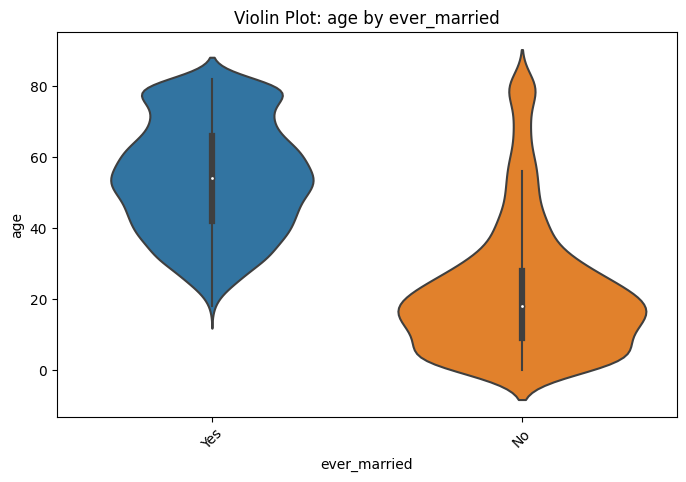

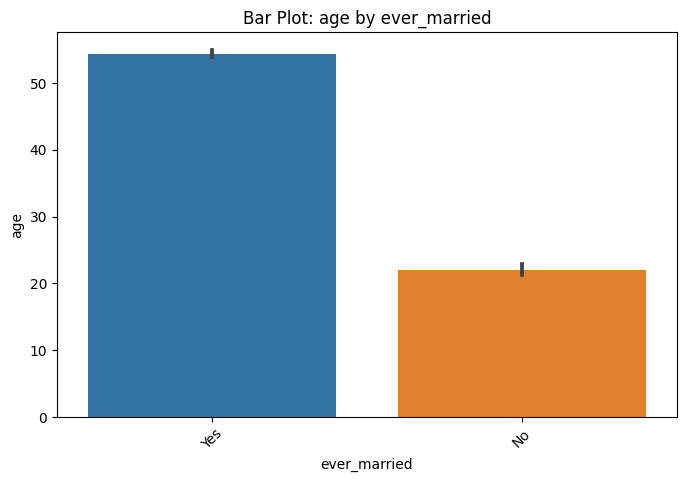

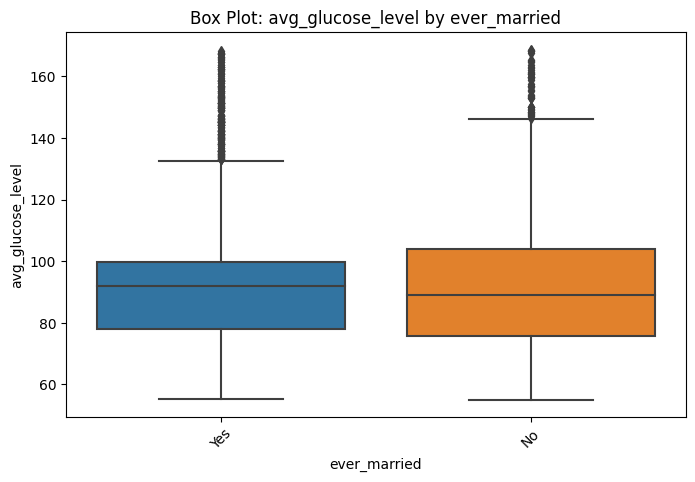

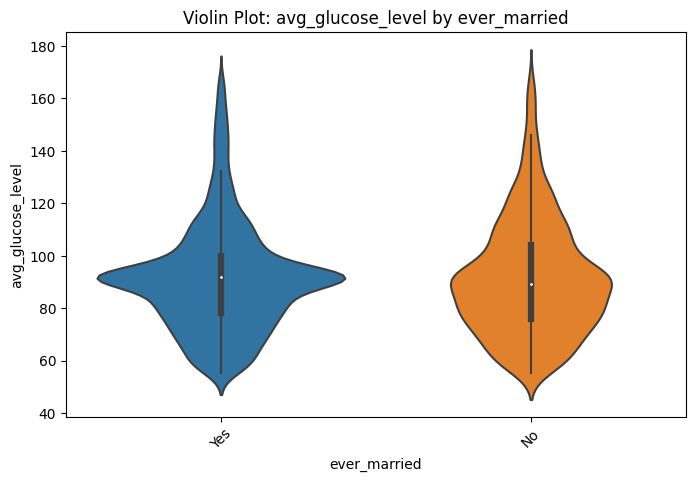

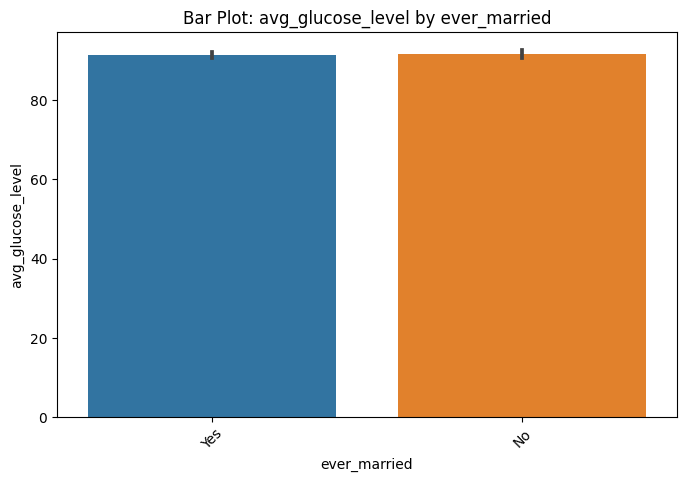

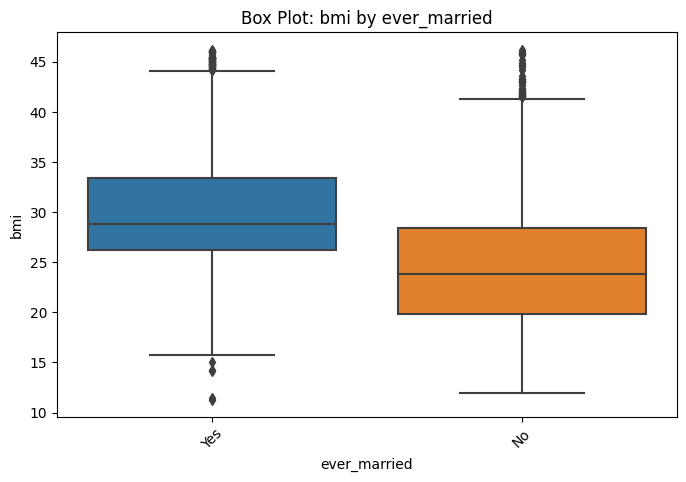

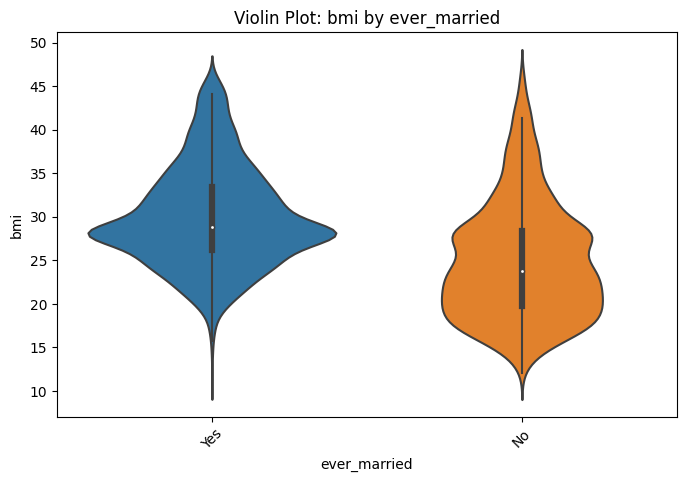

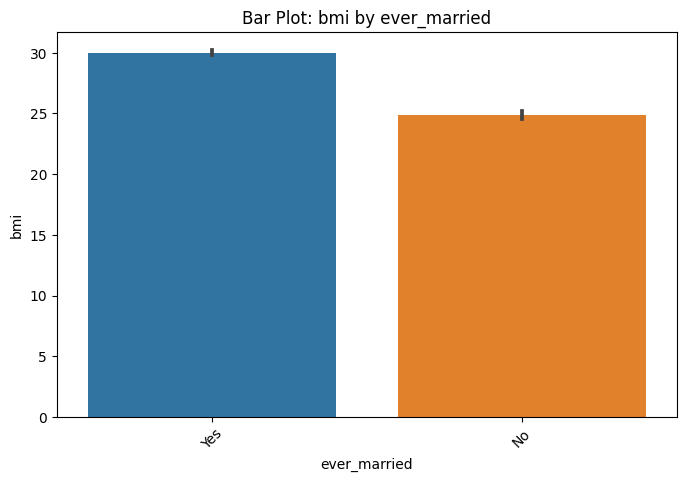

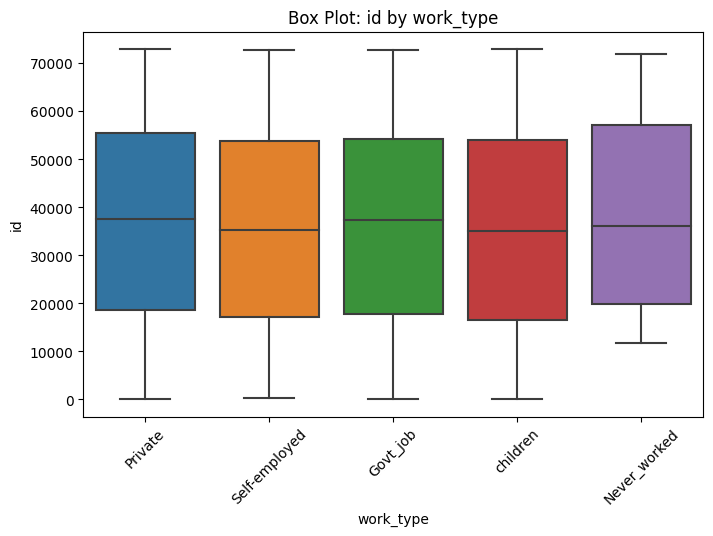

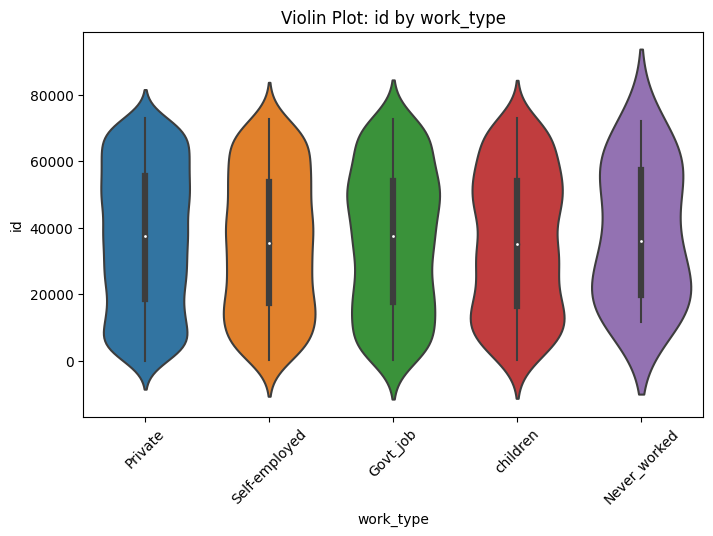

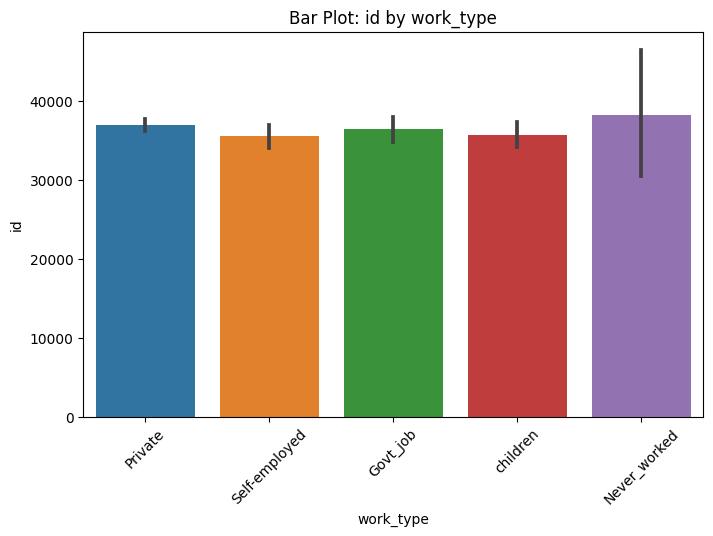

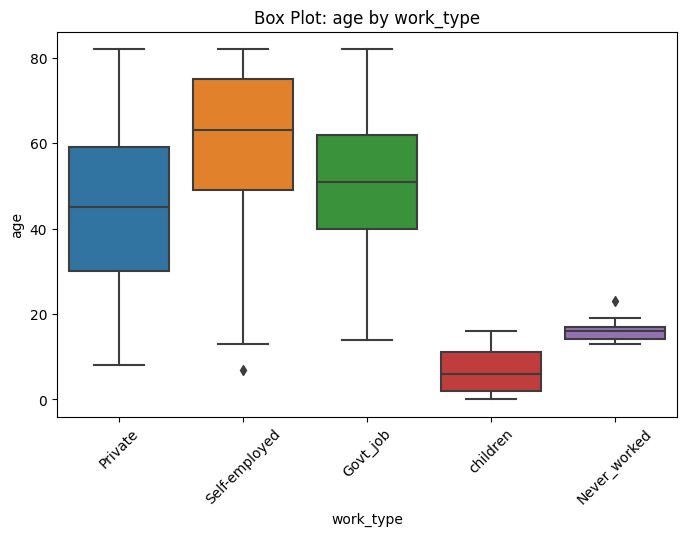

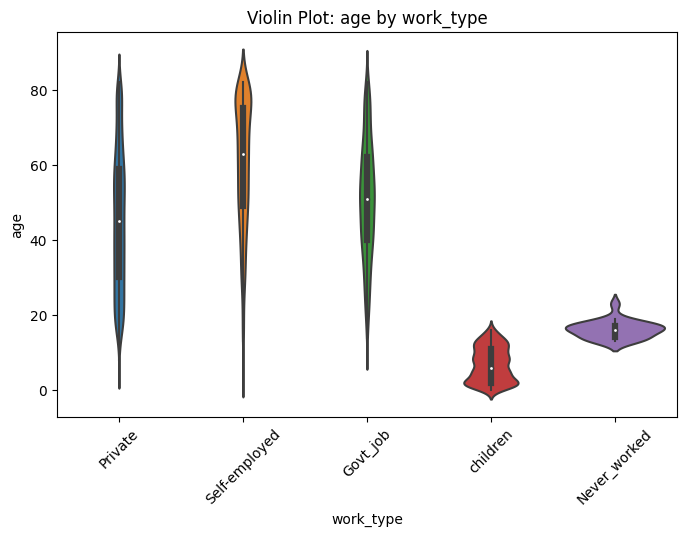

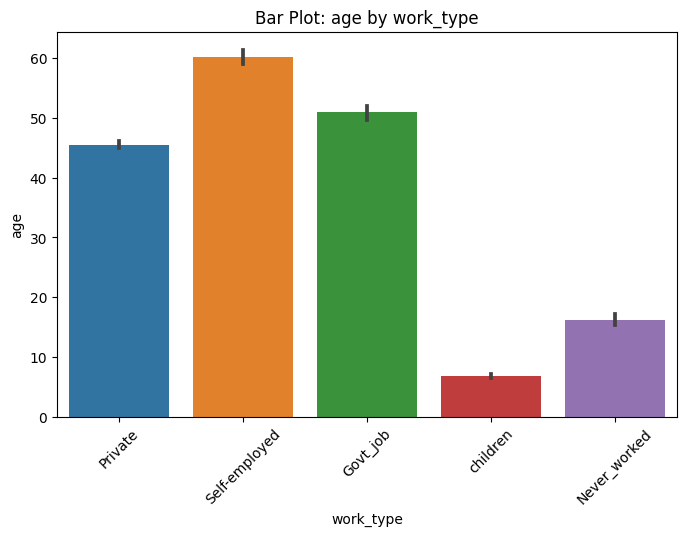

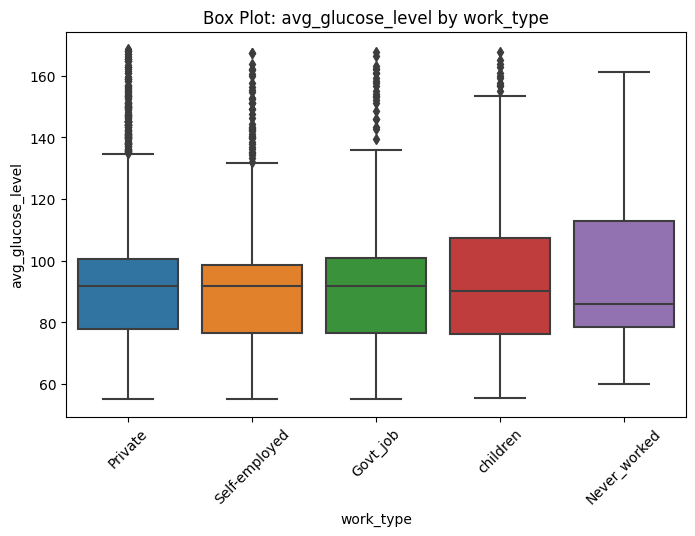

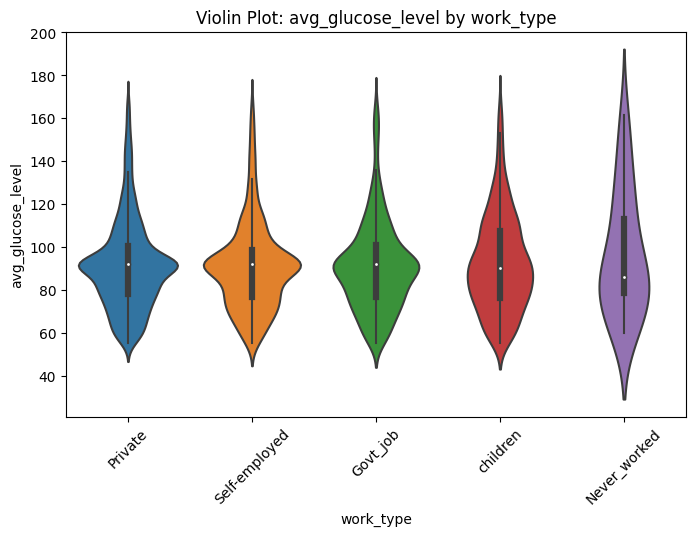

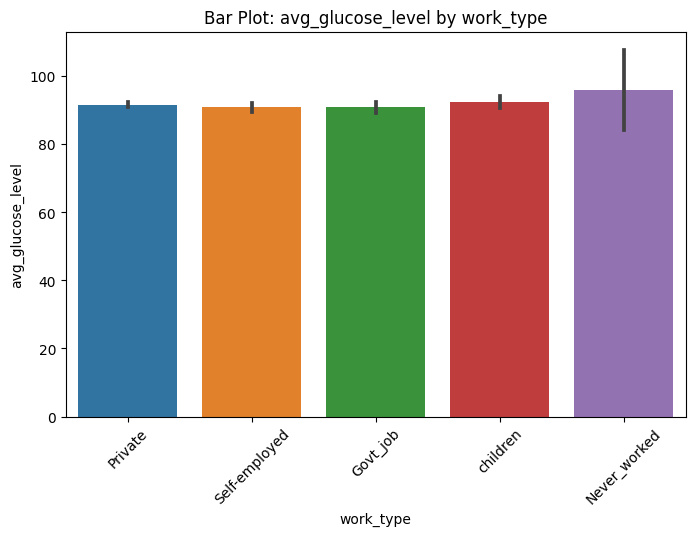

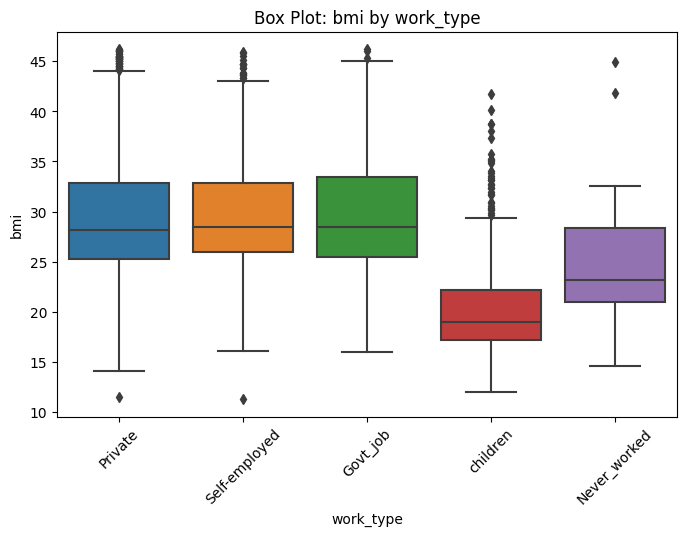

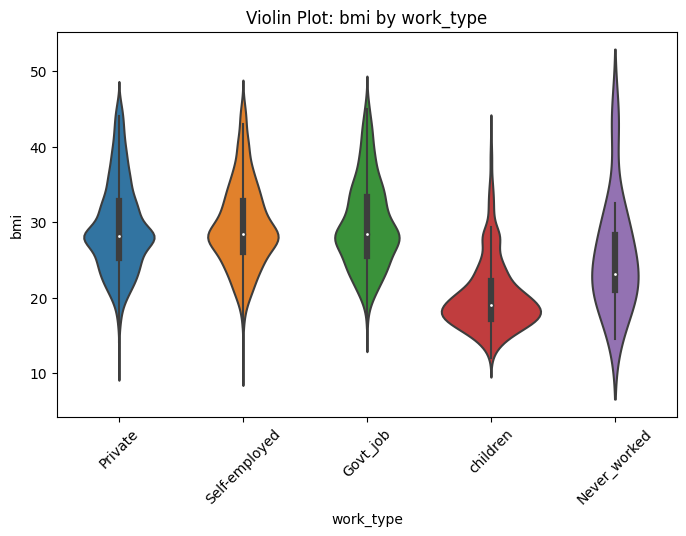

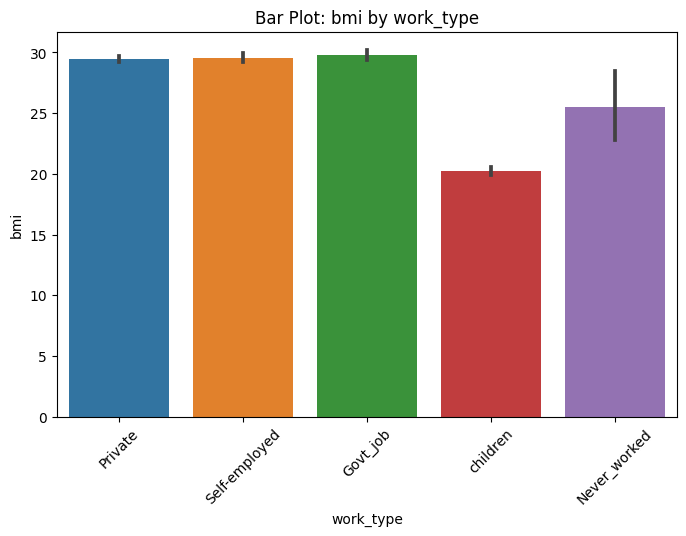

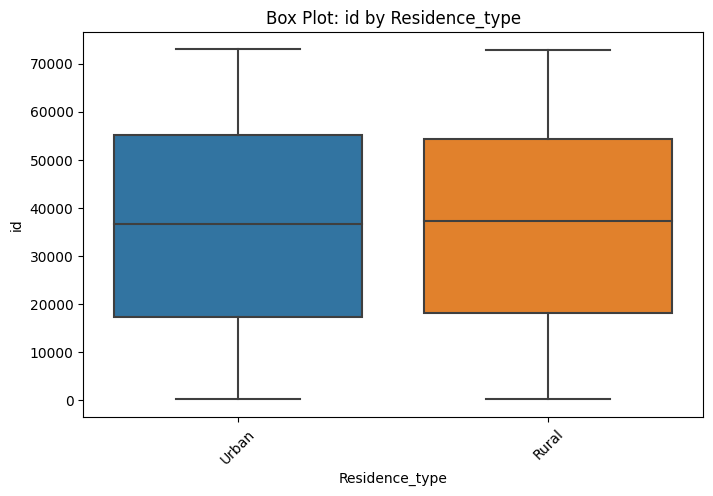

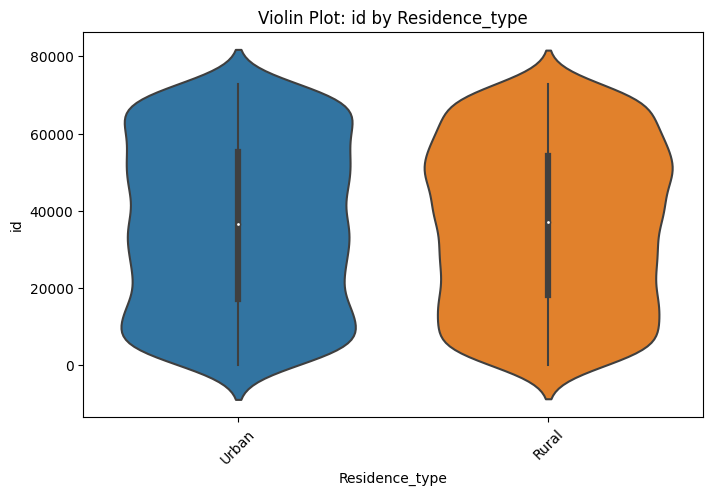

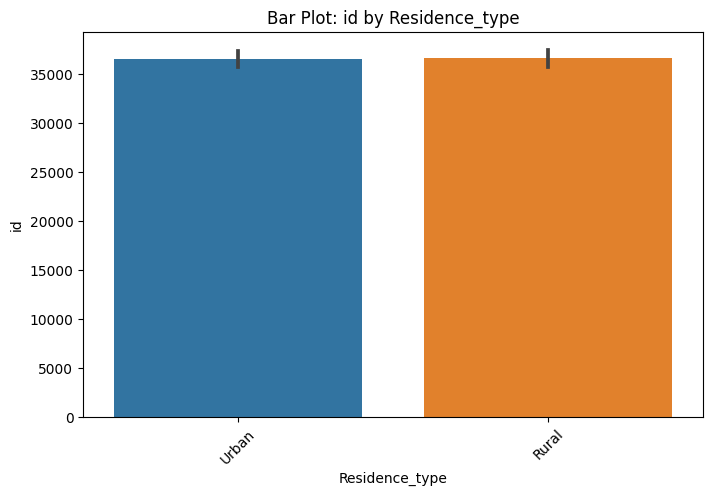

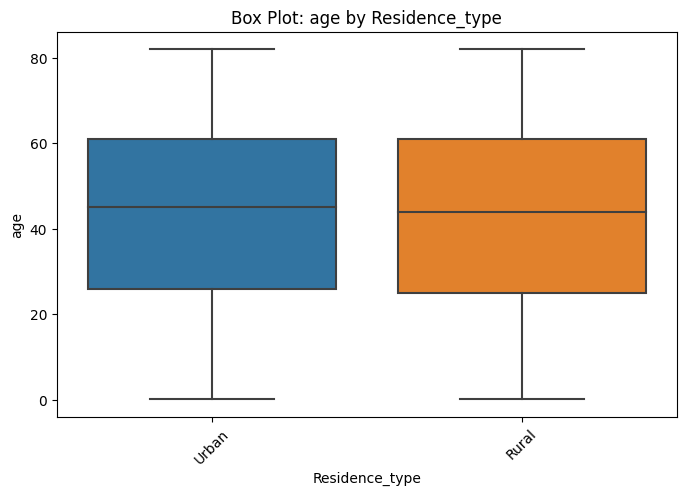

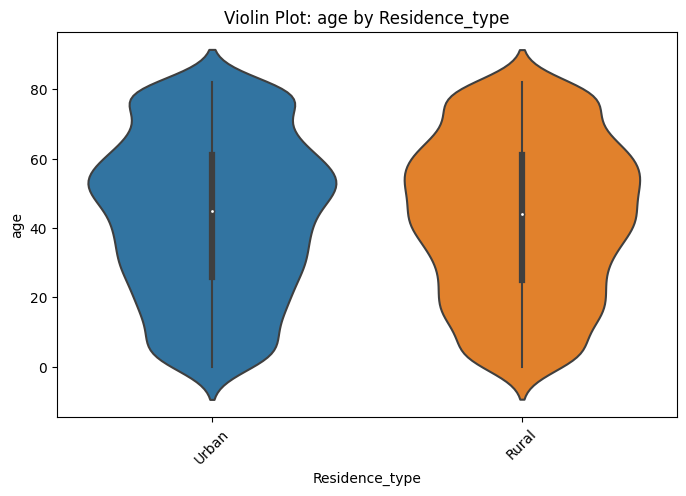

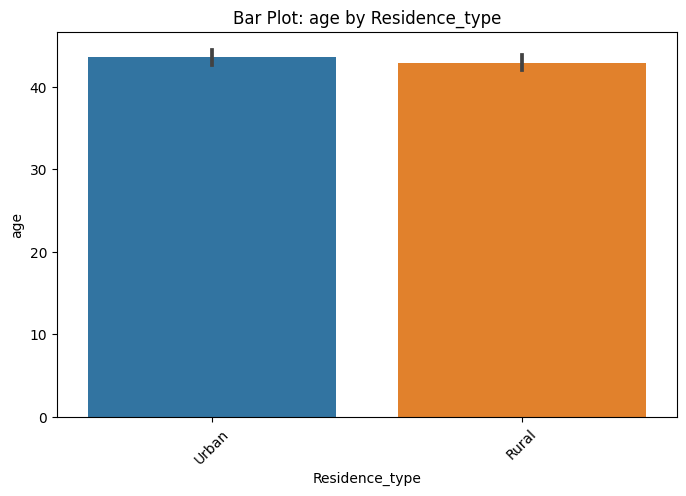

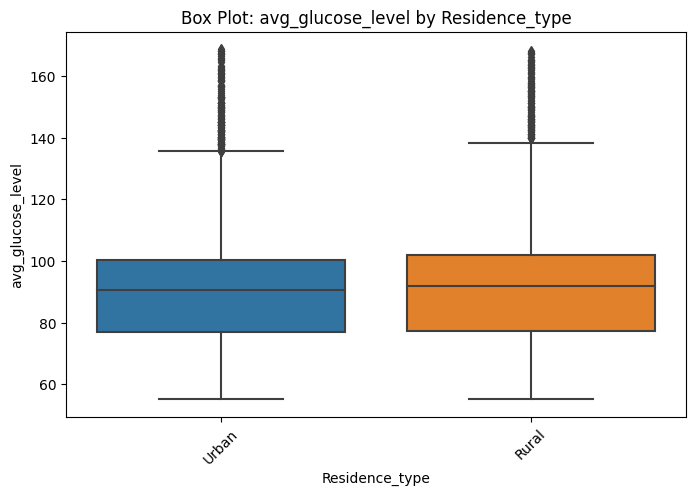

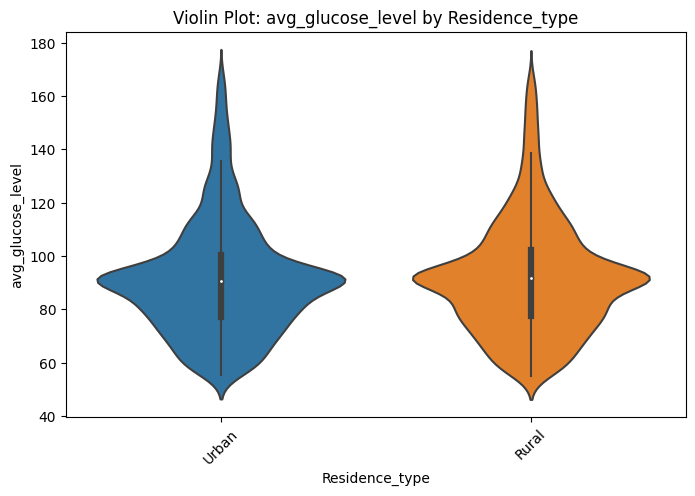

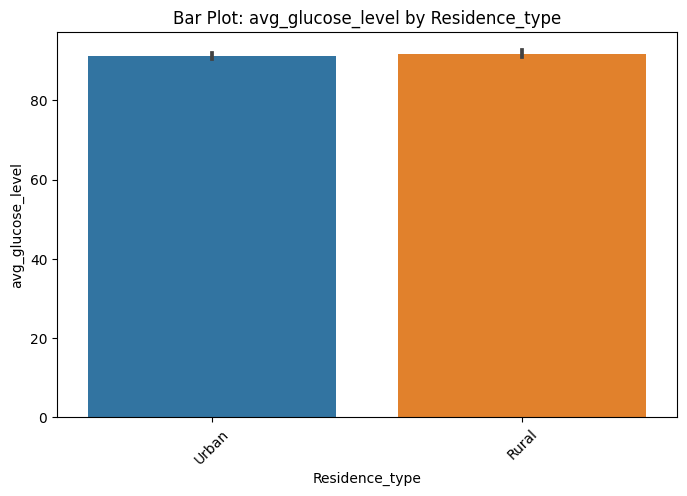

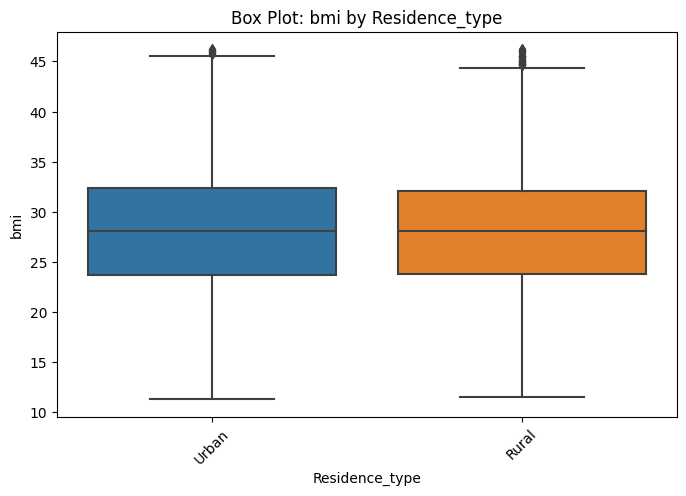

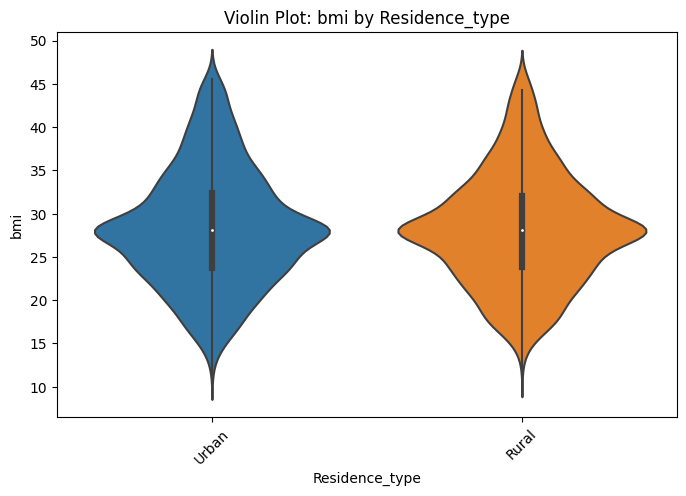

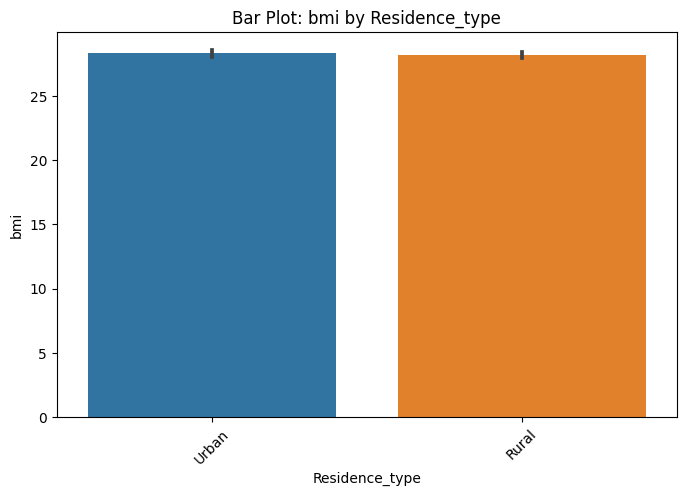

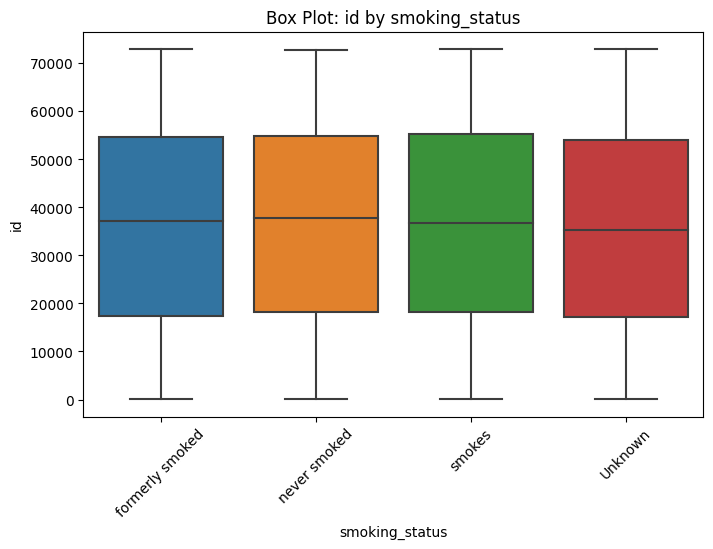

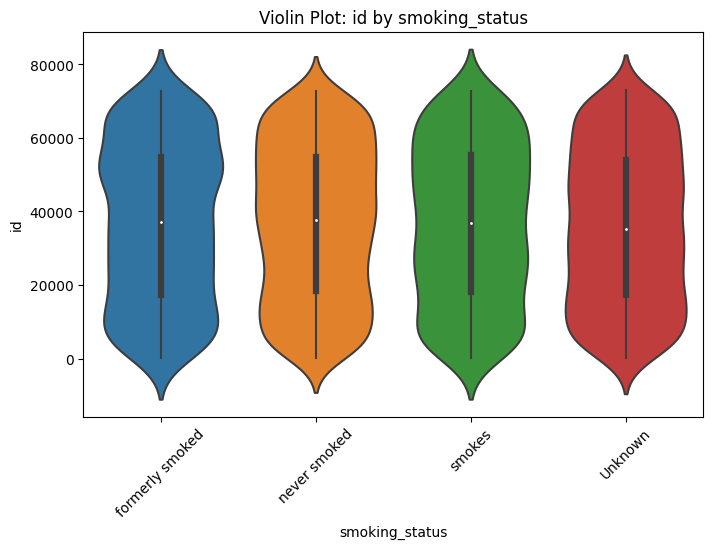

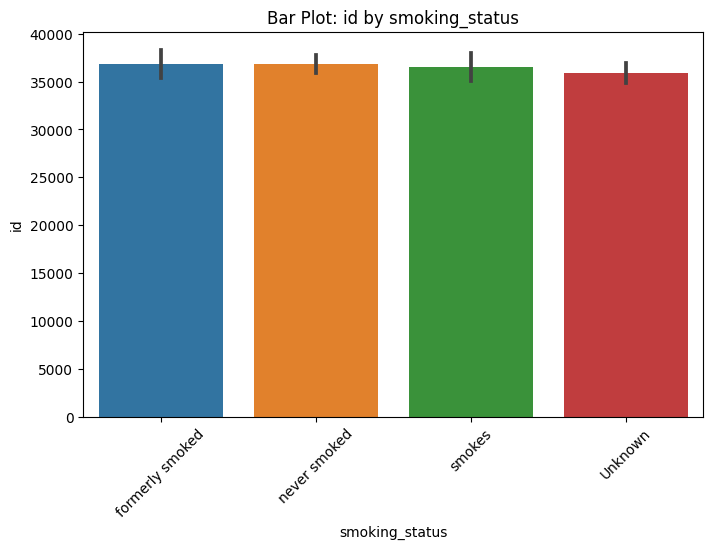

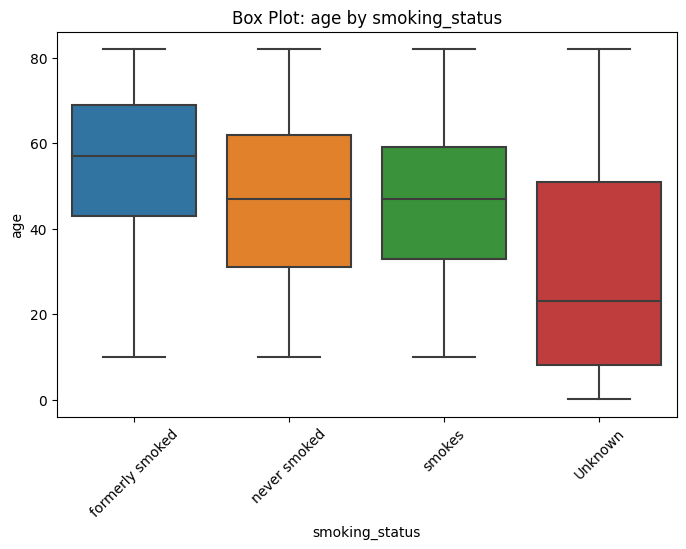

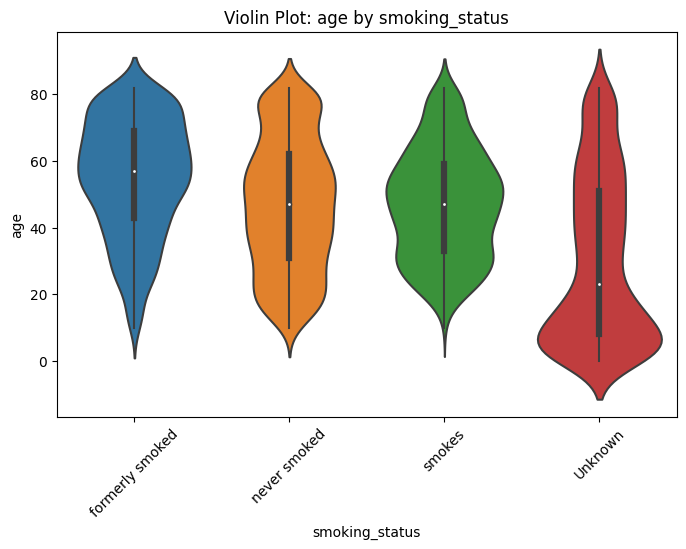

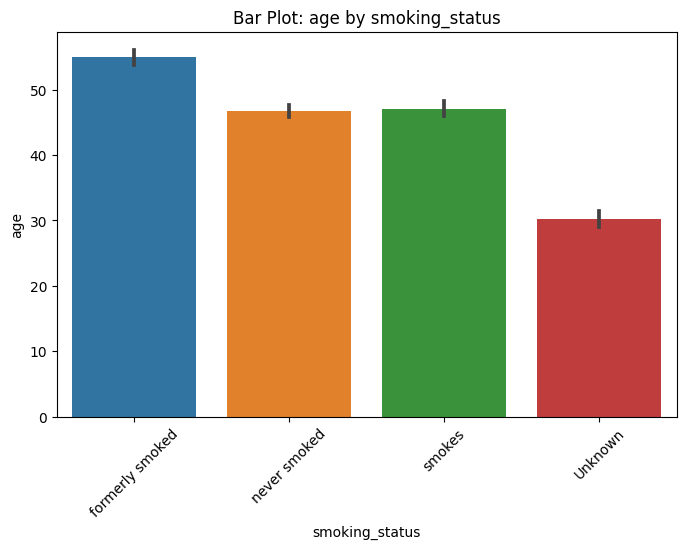

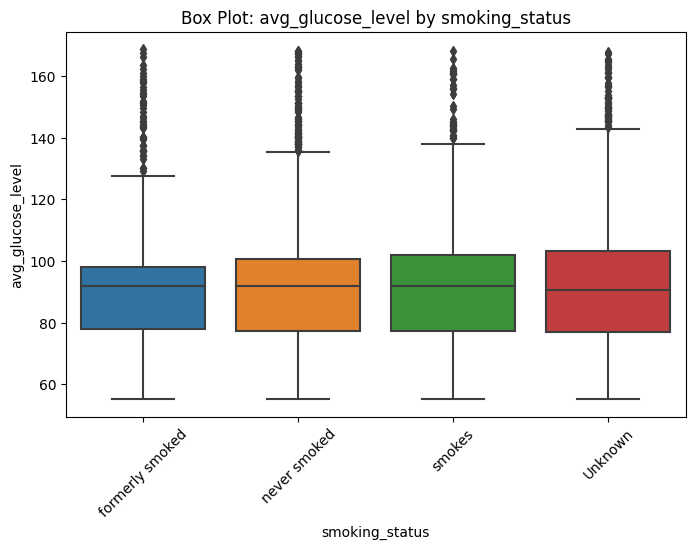

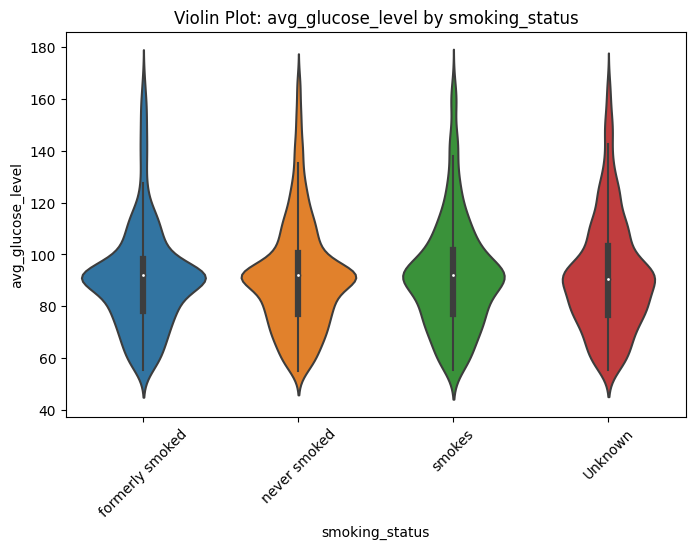

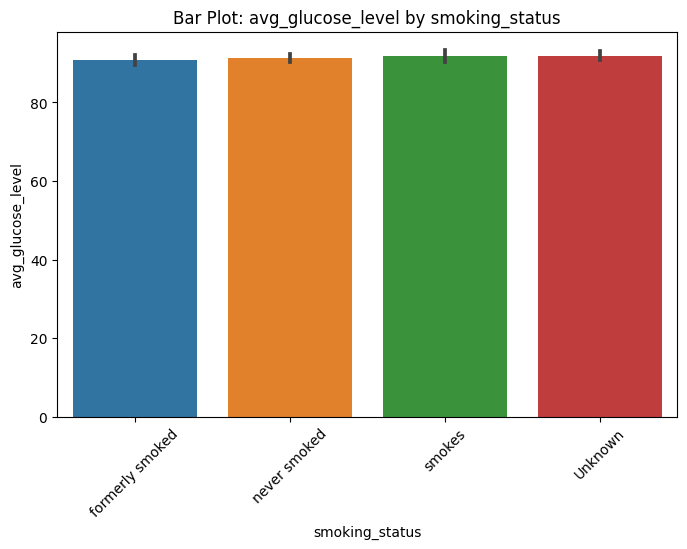

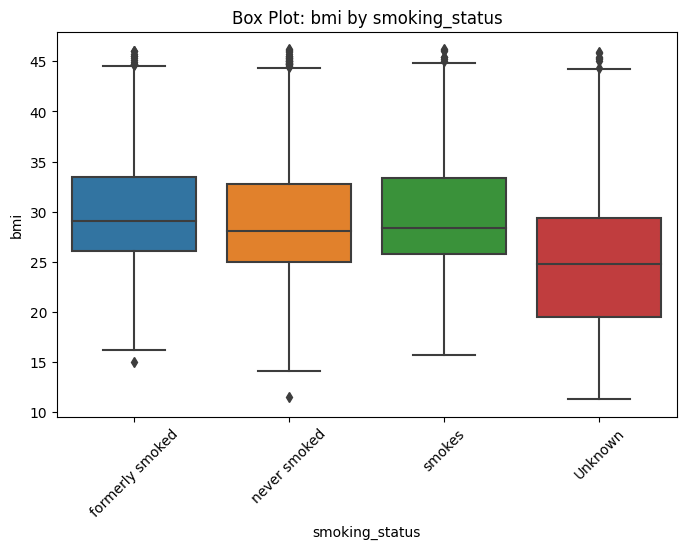

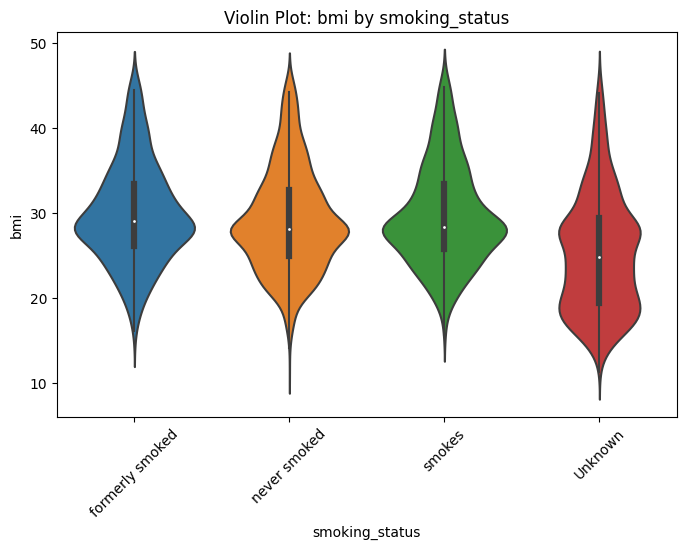

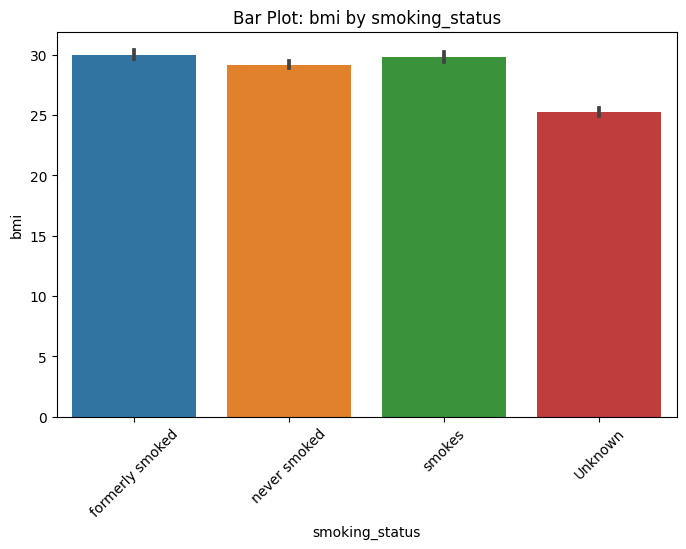

In [90]:
def categorical_numerical_analysis(df):
    for cat_col in categorical_columns:
        for num_col in numeric_columns:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x=df[cat_col], y=df[num_col])
            plt.xticks(rotation=45)
            plt.title(f"Box Plot: {num_col} by {cat_col}")
            plt.show()

            plt.figure(figsize=(8, 5))
            sns.violinplot(x=df[cat_col], y=df[num_col])
            plt.xticks(rotation=45)
            plt.title(f"Violin Plot: {num_col} by {cat_col}")
            plt.show()

            plt.figure(figsize=(8, 5))
            sns.barplot(x=df[cat_col], y=df[num_col])
            plt.xticks(rotation=45)
            plt.title(f"Bar Plot: {num_col} by {cat_col}")
            plt.show()
categorical_numerical_analysis(df)

# MULTIVARIATE ANALYSIS

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

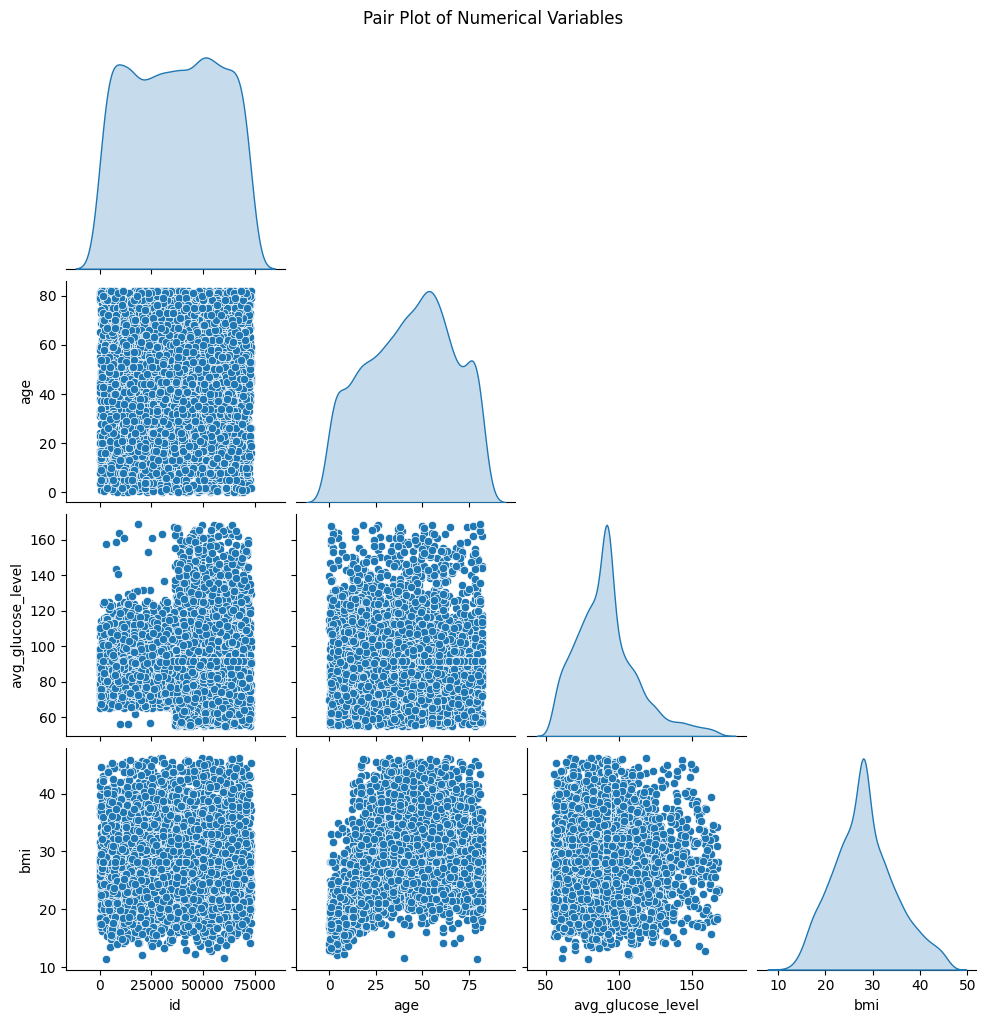

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[numeric_columns], diag_kind='kde', corner=True)
plt.suptitle("Pair Plot of Numerical Variables", y=1.02)
plt.show()


# Clusterred Stacked Bar Graph 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

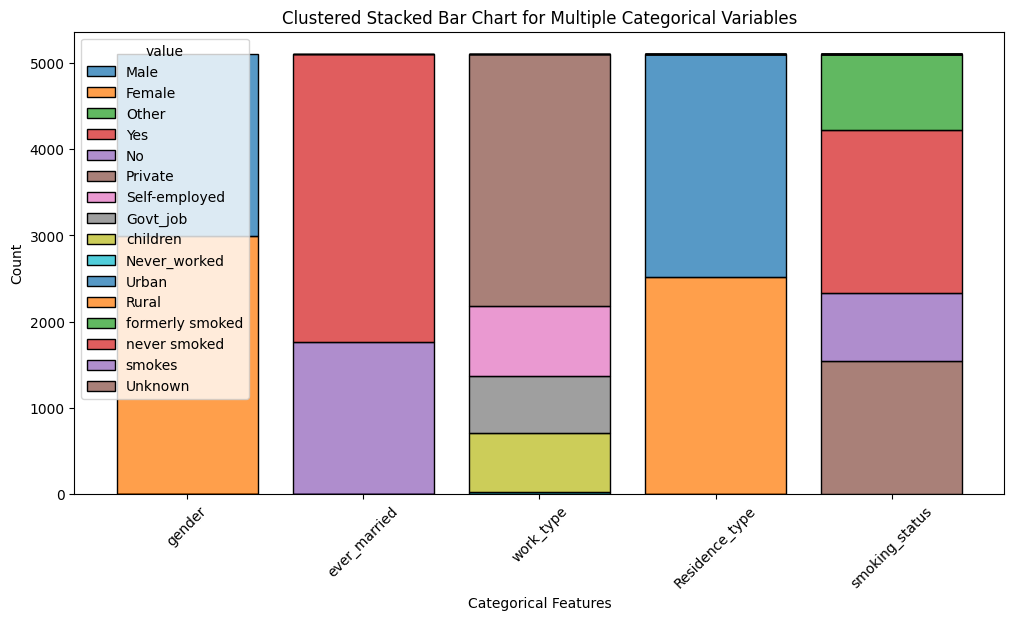

In [102]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df_melted = df.melt(id_vars=[], value_vars=categorical_columns)
plt.figure(figsize=(12, 6))
sns.histplot(data=df_melted, x="variable", hue="value", multiple="stack", shrink=0.8, palette="tab10")
plt.title("Clustered Stacked Bar Chart for Multiple Categorical Variables")
plt.xlabel("Categorical Features")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()
